In [1]:
import cv2
import json
import treepoem
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
from generator import aligned_affine

In [85]:
def coords_to_regions(coords, dimensions):
    res = []
    for i in range(len(coords)):
        ptsx, ptsy = coords[i]
        
        res.append({\
        'shape_attributes': {
            'name': 'polygon',
            'all_points_x': list(ptsx),
            'all_points_y': list(ptsy)
        },
        'region_attributes': {'barcode': dimensions[i]}})
    return res

In [82]:
def generate_distorted(barcode_types, content_barcodes, distortions=None):
    if distortions is None:
        distortions = np.random.randn(len(barcode_types), 2, 3)
    barimgs = [treepoem.generate_barcode(typ, content) for typ, content in zip(barcode_types, content_barcodes)]
    imgs, coords = zip(*[aligned_affine(np.array(img), dis) for img, dis in zip(barimgs, distortions)])
    masks, _ = zip(*[aligned_affine(np.ones_like(img), dis) for img, dis in zip(barimgs, distortions)])
    width, height = np.max(coords, axis=(0, 2))*2
    combined = np.zeros((int(width), int(height), 3))
    for i in range(len(imgs)):
        w, h, _ = imgs[i].shape
        dw = np.random.randint(0, width - w)
        dh = np.random.randint(0, height - h)
        coords[i][0] += dw
        coords[i][1] += dh
        expanded_img = np.zeros_like(combined)
        expanded_img[dw:w+dw, dh:h+dh] = imgs[i]
        expanded_mask = np.zeros_like(combined)
        expanded_mask[dw:w+dw, dh:h+dh] = masks[i]
        combined = combined*(1-expanded_mask) + expanded_img
    return combined, coords

In [83]:
img, coords = generate_distorted(['ean13', 'ean13', 'ean13'], ['100000011111', '100000011111', '100000011111'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


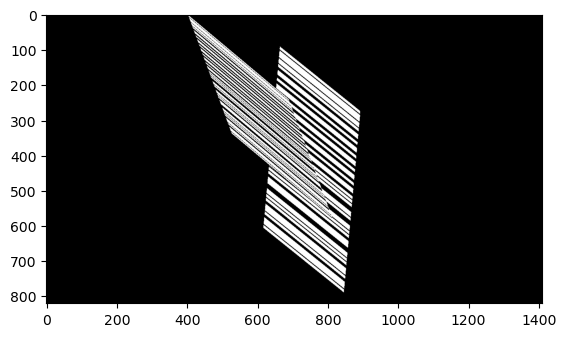

In [84]:
plt.imshow(img)

In [5]:
def export(img, name, coords, dimensions):
    plt.imsave(f'{name}.jpg', img)
    ptsx, ptsy = coords
    res = {f'{name}.jpg813086': {'filename': f'../code/{name}.jpg',
    'size': 813086,
    'regions': coords_to_regions(coords, dimensions),
    'file_attributes': {}}}
    save_json(res, f'{name}.json')

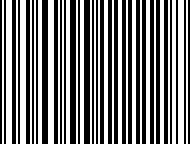

In [6]:
barimg = treepoem.generate_barcode('ean13', '100000011111')
barimg

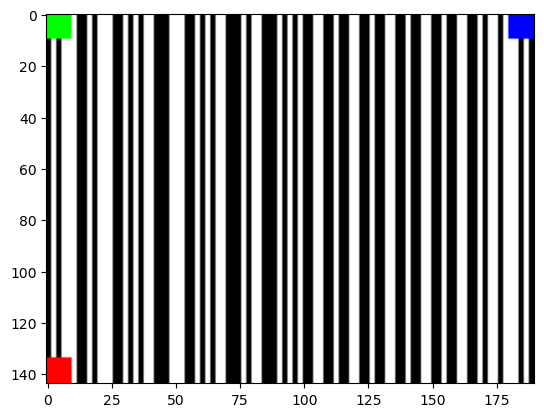

In [7]:
bar = np.array(barimg).copy()
bar[-10:, :10] = [255, 0, 0]
bar[:10, :10] = [0, 255, 0]
bar[:10, -10:] = [0, 0, 255]

plt.imshow(bar)

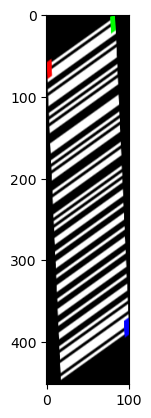

In [25]:
# M = [
#     [1, 0, 0.],
#     [0, 1, 0.]
# ]
# M = np.array(M)
M = np.random.randn(2, 3)
M[:, -1] = np.abs(M[:, -1]*100)
img, coords = aligned_affine(bar, M.copy(), fix_position=True)
plt.imshow(img)

In [37]:
coords

array([[  0.        ,  83.19075441, 100.73002748,  17.53927308],
       [ 59.67823196,   0.        , 392.20617304, 451.884405  ]])

In [36]:
np.min([coords, coords, coords], axis=(0, 2))

array([0., 0.])

In [ ]:
def load_json(fname, *args, **kwargs):
    with open(fname) as f:
        return json.load(f, *args, **kwargs)

def save_json(jd, fname, *args, indent=4, **kwargs):
    with open(fname, 'w') as f:
        json.dump(jd, f, *args, indent=indent, **kwargs)

In [ ]:
load_json('../dataset/multiple_barcodes_example.json')

In [94]:
len('100000011111')

12

In [95]:
treepoem.barcode_types['code93']

In [93]:
np.random.choice(list(treepoem.barcode_types), 7)

array(['databarlimitedcomposite', 'japanpost', 'ean14', 'hanxin',
       'rectangularmicroqrcode', 'microqrcode', 'micropdf417'],
      dtype='<U31')